In [2]:
!pip3 install opencv-python

     |████████████████████████████████| 42.6 MB 312 kB/s  eta 0:00:01   |██▍                             | 3.2 MB 5.4 MB/s eta 0:00:08


In [61]:
#!/usr/bin/env python3

# Imports!
import os
import random
import pandas as pd
import cv2
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

import model

In [62]:
# Config and Inits
data_dir = "../chest_xray"
size = (256, 256)

In [63]:

# Fucntions!
def img_2_arr(
    img_path: str,
    resize: bool = False,
    grayscale: bool = True,
    size: tuple = (256, 256),
) -> np.ndarray:

    """
    This function is responsible for opening an image, Preprocessing
    it by color or size and returning a numpy array.

    Input:
        - img_path: str, a path to the location of a image file on disk
        - resize: bool, True/False if the image is to be resized
        - grayscale: bool, True/False if image is meant to be B&W or color
        - size: tuple, a 2d tuple containing the x/y size of the image.

    Output:
        - a np.ndarray which is assosiated to the image that was input.
    """

    if grayscale:
        img_arr = cv2.imread(img_path, 0)
    else:
        img_arr = cv2.imread(img_path)

    if resize:
        img_arr = cv2.resize(img_arr, size)

    return img_arr


In [64]:

def create_datasets(data_dir: str) -> np.ndarray:
    """
    This function is responsible for creating a dataset which
    contains all images and their associated class.

    Inputs:
        - data_dir: str, which is the location where the chest x-rays are
            located.

    Outputs:
        - a np.ndarray which contains the processed image, and the class
            int, associated with that class.

    """
    # Image Loading and Preprocessing
    all_normal_img_paths = []
    all_viral_img_paths = []
    all_bact_img_paths = []
    # mac creates .DS_Store files which break original code
    directories = ["NORMAL", "PNEUMONIA"]
    for cls in directories: # NORMAL or PNEUMONIA
        for img in os.listdir(os.path.join(data_dir, cls)): # all images
            if cls == "NORMAL":
                all_normal_img_paths.append(os.path.join(data_dir, cls, img))
            elif "virus" in img:
                all_viral_img_paths.append(os.path.join(data_dir, cls, img))
            else:
                all_bact_img_paths.append(os.path.join(data_dir, cls, img))

    # 0 for normal, 1 for bacterial and 2 for viral
    dataset = (
        [
            [img_2_arr(path, grayscale=True, resize=True, size=size), 0]
            for path in all_normal_img_paths
        ]
        + [
            [img_2_arr(path, grayscale=True, resize=True, size=size), 1]
            for path in all_bact_img_paths
        ]
        + [
            [img_2_arr(path, grayscale=True, resize=True, size=size), 2]
            for path in all_viral_img_paths
        ]
    )

    return np.array(dataset, dtype="object")



In [65]:

def main():

    # get dataset
    dataset = create_datasets(data_dir)

    print(dataset)
    print(len(dataset))
    for i in dataset[0:2]:
        plt.imshow(i)


In [66]:
# get dataset
dataset = create_datasets(data_dir)

In [67]:
print(len(dataset))

990


In [68]:
dataset[0][0].shape

(256, 256)

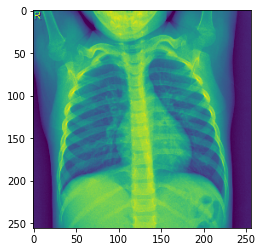

In [69]:
plt.imshow(dataset[110][0])

In [70]:
# counting distribution of each type
def get_counts(dataset):
    imageCount = [0,0,0]
    for i in dataset:
        imageCount[i[1]] += 1
    return imageCount

# 0 for normal, 1 for bacterial and 2 for viral
imageType = ['normal','bacterial','viral']
get_counts(dataset)

[273, 530, 187]

### Train test split

In [71]:
np.random.seed(42) # making model reproducible
# reshuffle the array to make sure we arent sampling only one class
np.random.shuffle(dataset)
train_set = dataset[0:int(len(dataset)*0.7)]
test_set = dataset[int(len(dataset)*0.7+1):int(len(dataset)*0.85)]
val_set = dataset[int(len(dataset)*0.85+1):len(dataset)]

In [72]:
train_set.shape, val_set.shape, test_set.shape

((693, 2), (148, 2), (147, 2))

In [73]:
get_counts(train_set), get_counts(val_set), get_counts(test_set)

([197, 368, 128], [44, 79, 25], [31, 82, 34])

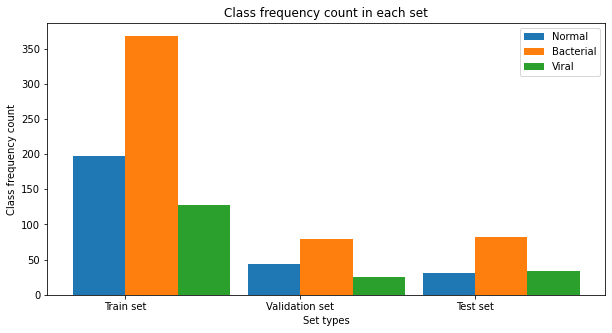

In [74]:
# distribution test 
n = 3
bar1 = (get_counts(train_set)[0], get_counts(val_set)[0], get_counts(test_set)[0])
bar2 = (get_counts(train_set)[1], get_counts(val_set)[1], get_counts(test_set)[1])
bar3 = (get_counts(train_set)[2], get_counts(val_set)[2], get_counts(test_set)[2])

ind = np.arange(n)
plt.figure(figsize=(10,5))
width = 0.3 
plt.bar(ind, bar1 , width, label='Normal')
plt.bar(ind + width, bar2, width, label='Bacterial')
plt.bar(ind + width*2, bar3, width, label='Viral')

plt.xlabel('Set types')
plt.ylabel('Class frequency count')
plt.title('Class frequency count in each set')

plt.xticks(ind + width / 2, ('Train set', 'Validation set', 'Test set'))

plt.legend(loc='best')
plt.show()
# adapted from https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged

In [157]:
# transforming data to x_train, y_train, x_test, y_test
X_train = np.array([i[0] for i in train_set])/255
y_train = np.array([i[1] for i in train_set])
X_val = np.array([i[0] for i in val_set])/255
y_val = np.array([i[1] for i in val_set])
X_test = np.array([i[0] for i in test_set])/255
y_test = np.array([i[1] for i in test_set])

In [158]:
# making labels into one hot encoding 
from tensorflow.keras.utils import to_categorical

In [159]:
y_cat_train = to_categorical(y_train, 3)
y_cat_val = to_categorical(y_val, 3)
y_cat_test = to_categorical(y_test, 3)

In [160]:
# Reshaping X_train, X_test
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_train.shape

(693, 256, 256, 1)

In [161]:
len(X_train.shape), X_train.shape[2]

(4, 256)

In [162]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)
X_test.shape

(147, 256, 256, 1)

In [163]:
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)
X_val.shape

(148, 256, 256, 1)

In [164]:
assert (((X_train > 1).sum()  == 0) and ((X_train < 0).sum()  == 0)), "Failed"

### Image Data Generator

In [165]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [166]:
image_gen = ImageDataGenerator(rotation_range=45, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [167]:
X_train[0].shape
np.squeeze(X_train[0]).shape

(256, 256)

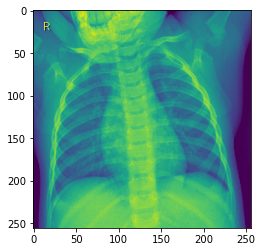

In [168]:
plt.imshow(np.squeeze(X_train[0]))

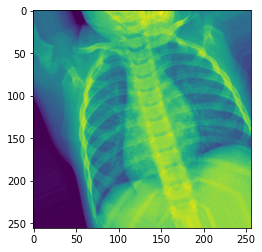

In [169]:
for i in range(0,len(X_train)):
    X_train[i] = image_gen.random_transform(X_train[i])
plt.imshow(np.squeeze(X_train[0]))

### Building the model

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [84]:
model = Sequential()

## Layer 1

# Convolutional layer
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(256, 256, 1), activation='relu',))
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layer 
model.add(Dropout(0.25))

## Layer 2

model.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten images from 58 by 58 to 430592 list before final layer
model.add(Flatten())

# 256 Neurons in dense Layer
model.add(Dense(256, activation='relu'))
# Last Dropout
model.add(Dropout(0.4))
# Since there are 3 classes, we add 3 neurons
model.add(Dense(3, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 253, 253, 32)      544       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 123, 123, 64)      32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 128)      

### Testing whether the model is stacking

In [86]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [87]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [90]:
model.fit(X_train, 
          y_cat_train,  
          epochs=2,
          validation_data=(X_val, y_cat_val),
          callbacks=[cp_callback]) 

Train on 693 samples, validate on 148 samples
Epoch 1/2
693/693 [==============================] - ETA: 0s - loss: 7.2861 - acc: 0.5152WARNING:tensorflow:From /Users/petrandreev/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: saving model to cp.ckpt
693/693 [==============================] - 36s 52ms/sample - loss: 7.2861 - acc: 0.5152 - val_loss: 7.5145 - val_acc: 0.5338
Epoch 2/2
693/693 [==============================] - ETA: 0s - loss: 7.5590 - acc: 0.5310
Epoch 00002: saving model to cp.ckpt
693/693 [==============================] - 39s 56ms/sample - loss: 7.5590 - acc: 0.5310 - val_loss: 7.5145 - val_acc: 0.5338


In [ ]:
tf.train.
model.load_weights()

In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#tf.compat.v1.disable_eager_execution()
#image = tf.keras.Input(name="dummy", shape=(None, 256, 256, 1), dtype=tf.dtypes.float32)

image = tf.placeholder(tf.float32, (None, 256, 256, 1))
sess = tf.Session()
sess.run(tf.global_variables_initializer())
before = sess.run(tf.trainable_variables())
_ = sess.run(model.train, feed_dict={
           image: np.ones((1, 100, 100, 3)),
           })
after = sess.run(tf.trainable_variables())
for b, a, n in zip(before, after):
  # Make sure something changed.
  assert (b != a).any()


AttributeError: module 'model' has no attribute 'train'

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [73]:
model.fit(X_train,y_cat_train,epochs=1,validation_data=(X_val,y_cat_val),callbacks=[early_stop])

22/22 [==============================] - 35s 2s/step - loss: 2.0139 - accuracy: 0.5036 - val_loss: 1.0873 - val_accuracy: 0.5338


### Evaluating the model

In [156]:
model.metrics_names

['loss', 'accuracy']

In [157]:
losses = pd.DataFrame(model.history.history)

In [158]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.739638,0.708514,0.553696,0.829932
1,0.679901,0.757576,0.524512,0.857143
2,0.513915,0.813853,0.456437,0.857143
3,0.571085,0.796537,0.482363,0.829932
4,0.390239,0.858586,0.408895,0.891156


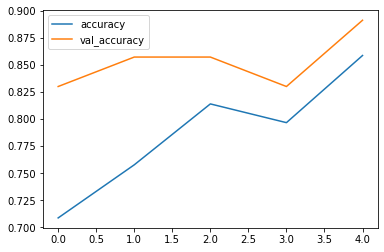

In [159]:
losses[['accuracy','val_accuracy']].plot()

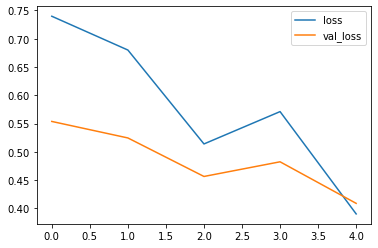

In [160]:
losses[['loss','val_loss']].plot()

In [161]:
print(model.metrics_names)
print(model.evaluate(X_test,y_cat_test,verbose=0))

['loss', 'accuracy']
[0.4088952839374542, 0.8911564350128174]


In [31]:
from sklearn.metrics import classification_report,confusion_matrix

In [75]:
predictions = model.predict_classes(X_test)
preds = model.predict(X_test)
preds = np.argmax(preds,axis=1)


In [29]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [76]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        31
           1       0.56      1.00      0.72        82
           2       0.00      0.00      0.00        34

    accuracy                           0.56       147
   macro avg       0.52      0.34      0.26       147
weighted avg       0.52      0.56      0.41       147



/Users/petrandreev/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
import seaborn as sns

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_cat_test,predictions),annot=True)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

<Figure size 720x432 with 0 Axes>